# Code to calculate desired evaluation metrics from best run timeseries

## import library and define functions

In [95]:
import numpy as np
import yaml
import os
import warnings
import json
import hydroeval as he
import pandas as pd
from tqdm import tqdm

In [96]:
def calculate_nse(modeled_data, observed_data):
    mean_observed = np.mean(observed_data)
    numerator = np.sum(np.power(observed_data - modeled_data, 2))
    denominator = np.sum(np.power(observed_data - mean_observed, 2))
    return 1 - np.divide(numerator, denominator)

def load_basin_list(basin_filename):
    with open(basin_filename, 'r') as file:
        lines = file.readlines()
        # Remove leading/trailing whitespaces and newline characters
        lines = [line.strip() for line in lines]
    basin_list_str = lines
    return basin_list_str

def load_time_index(time_split_file):
    with open(time_split_file) as f:
        time_split = json.load(f)
        print(time_split)
        start_time = time_split['calibration']['start_datetime']
        end_time = time_split['calibration']['end_datetime']
        hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')
    return hourly_index, start_time, end_time

def load_best_run_timeseries(best_runs_dir, basin_id, hourly_index): # Get the file names in the directory
    best_runs_files = os.listdir(best_runs_dir)
    best_run_for_a_basin = [file_name for file_name in best_runs_files if file_name.startswith(basin_id)]
    if len(best_run_for_a_basin)==1:
        with open(os.path.join(best_runs_dir, best_run_for_a_basin[0])) as f:
            best_run = json.load(f)
    elif len(best_run_for_a_basin)==0:
        warnings.warn("No calibration was done for this basin")
    elif len(best_run_for_a_basin)>1:
        warnings.warn("Multiple calibration runs are mixed up in one folder, check")
    best_run_timeseries = pd.DataFrame(best_run['best simulation results'], columns=['simulated'])
    best_run_timeseries.set_index(hourly_index, inplace=True)
    return best_run_timeseries
    
def load_obs_timeseries(obs_data_dir, start_time, end_time, basin_id):
    obs_data_files = os.listdir(obs_data_dir)
    obs_data_file = [file_name for file_name in obs_data_files if file_name.startswith(basin_id)]

    if len(obs_data_file)==1:
        obs_data_ = pd.read_csv(os.path.join(obs_data_dir, obs_data_file[0]))
    else:
        warnings.warn("data is gone!")
        
    obs_data_['date'] = pd.to_datetime(obs_data_['date'])
    obs_data_.set_index(obs_data_['date'], inplace=True)
    obs_data = obs_data_[start_time:end_time]
    
    return obs_data

    

## Read configs

In [97]:
# Read the config file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Access the config variables
results_dir = config['io_dir']['results_dir'].replace("${cwd}", "..")
best_runs_dir = os.path.join(results_dir, 'best_runs')
basin_filename = config['model_settings']['basin_file'].replace("${cwd}", "..")
time_split_file = config['model_settings']['time_split_file'].replace("${cwd}", "..")
obs_data_dir = config['io_dir']['usgs_streamflow_dir'].replace("${cwd}", "..")

## Loop through basins and evaluate

                                   date  QObs(mm/h)  QObs count  \
date                                                              
1999-10-01 00:00:00 1999-10-01 00:00:00    0.040504           4   
1999-10-01 01:00:00 1999-10-01 01:00:00    0.039983           4   
1999-10-01 02:00:00 1999-10-01 02:00:00    0.039723           4   
1999-10-01 03:00:00 1999-10-01 03:00:00    0.039593           4   
1999-10-01 04:00:00 1999-10-01 04:00:00    0.039203           4   

                                      qualifiers  utcoffset(h)  \
date                                                             
1999-10-01 00:00:00  A [91]/A [91]/A [91]/A [91]          -4.0   
1999-10-01 01:00:00  A [91]/A [91]/A [91]/A [91]          -4.0   
1999-10-01 02:00:00  A [91]/A [91]/A [91]/A [91]          -4.0   
1999-10-01 03:00:00  A [91]/A [91]/A [91]/A [91]          -4.0   
1999-10-01 04:00:00  A [91]/A [91]/A [91]/A [91]          -4.0   

                     (iv-camels)/camels  QObs_CAMELS(mm/h)     simu

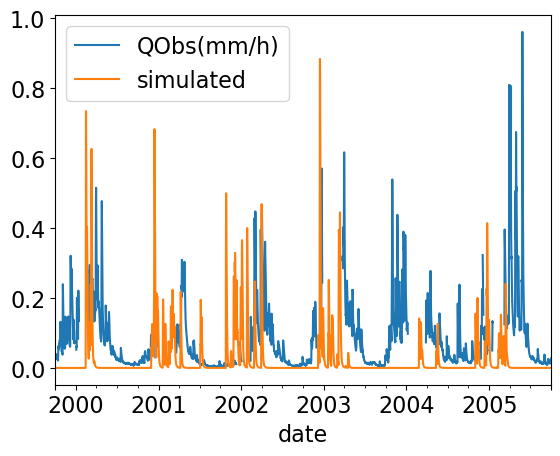

In [105]:
# To test one basin
# i=0
# basin_id = basin_list_str[i]
# for basin_id in ([basin_list_str[i]]):

# Initialize
basin_list_str = load_basin_list(basin_filename)
df_results = pd.DataFrame(columns=['BasinID', 'NSE'])
plot_results = False

# Loop through all the basins
for basin_id in tqdm(basin_list_str):

    # Load time split
    hourly_index, start_time, end_time = load_time_index(time_split_file)
    
    # Load and combine obs & simulated data 
    best_run_timeseries = load_best_run_timeseries(best_runs_dir=best_runs_dir, basin_id=basin_id, hourly_index=hourly_index)
    obs_data = load_obs_timeseries(obs_data_dir=obs_data_dir, start_time=start_time, end_time=end_time, basin_id=basin_id)
    df_eval_sim = obs_data.join(best_run_timeseries)
    
    # If you want to plot results
    if plot_results: 
        print(df_eval_sim.head())
        df_eval_sim[['QObs(mm/h)', 'simulated']].plot()
        
    # Evalute (you can add as many eval metrics here)
    modeled_data = df_eval_sim['simulated'].values
    observed_data = df_eval_sim['QObs(mm/h)'].values
    nse_ = calculate_nse(modeled_data=modeled_data[~np.isnan(observed_data)], observed_data=observed_data[~np.isnan(observed_data)])
    
    df_results = pd.concat([df_results, pd.DataFrame({'BasinID': [basin_id], 'NSE': [nse_]})])

# Reset the index of the DataFrame
df_results = df_results.reset_index(drop=True)

# Print the results DataFrame
print(df_results)
df_results.to_csv(os.path.join(best_runs_dir, 'best_runs_eval.csv'))